In [333]:
from datetime import datetime, timedelta
import os
import time
import requests
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import doctor
import math
from IPython.display import clear_output
import main
import seaborn as sea
import matplotlib.patches as patches
import matplotlib as mpl
import ryan_tools as rt
import keras as kr

C:\Users\rfrancis\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Open

In [3]:
def plot_candles(candles, signal, fig, ax):
    def add_rectangle(i, open_, close,low, high, ax, sig):
        x = i - .5
        y = min(open_, close)
        height = abs(open_ - close)
        if sig == 'buy':
            color = 'green'
            hatch = 'x'
        if sig == 'sell':
            color = 'red'
            hatch = ''
            
        if sig == 'wait':
            color = 'orange'
            hatch = ''
        ax.add_patch(patches.Rectangle((x, y), .9, height,
                                       fill = open_ <= close, facecolor = color,
                                       edgecolor = color, hatch = hatch ))
        top = max(open_,close)
        bottom = min(open_,close)

        if low < bottom:
            ax.add_line(mpl.lines.Line2D([i,i], [low, bottom], color = color) )

            
        if high > top:
            ax.add_line(mpl.lines.Line2D([i,i], [high, top], color = color) )

        
    for i, index in enumerate(candles.index):
        sig = signal.loc[index]
        row = candles.loc[index]
        add_rectangle(i, row['open'], row['close'],row['low'], row['high'],  ax, sig)
    ax.set_xlim(0, len(candles))
    ax.set_ylim(candles['close'].min() *.998, candles['close'].max() * 1.002)
    return ax

In [4]:
def chartio(gran = 60, cans = False, count = False):
    if type(cans) == type(False):
        cans = aba.get_candles(granularity= gran)
    if count == False:
        count = len(cans)
    mask = cans['open']< cans['close']
    signal = pd.Series(index = cans.index )
    signal.loc[mask] = 'buy'
    signal.loc[~mask] = 'sell'

    
    
    fig, (ax, sig_ax) = plt.subplots(nrows = 2, sharex= False)
    fig.set_size_inches(7, 9)
    plot_candles(cans[-count:], signal[-count:], fig, ax)
    ax.set_xticklabels(cans.index)
    ax2 = ax.twinx()
    cans.iloc[-count:]['volume'].plot(kind = 'bar', ax = ax2, alpha = 0.3)
    

    rsi = aba.get_rsi(cans['close'])
    macd = aba.get_macd(cans)
    rsi.plot(ax = sig_ax, alpha = 0.1)
    ax4 = sig_ax.twinx()
    macd[['macd', 'macd_signal']].plot(ax = ax4)
    plt.show()
    

In [5]:
aba = main.Abathor('LTC-USD')

In [258]:
observations = []

def get_random_candles():
    days = np.random.randint(1, 500)
    hours = np.random.randint(0, 12)
    minutes = np.random.randint(0,60)
    start = datetime.today() - timedelta(days = days, hours = hours, minutes = minutes )
    end = start + timedelta(seconds = 60 * 200)
    cans =  aba.get_candles(start, end)
    observations.append(cans)
    return cans

In [614]:
bar = rt.progress_bar(100)
for num in range(0, 100):
    get_random_candles()
    bar.progress()

0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o> | 100.00 % 
Done: 99 Remaining: 1, Remaining Time: 1s


In [626]:
def create_data(candle_list, candles_before = 10):
    X = []
    y = []
    ar = np.array
    bar = rt.progress_bar(len(candle_list))
    for candles in candle_list:
        bar.progress()
        changes = candles.copy()
        changes[['low', 'high', 'open', 'close', 'volume']] = np.log(changes[['low', 'high', 'open', 'close', 'volume']]).diff().bfill()

        for index in changes.index:
            change_percent = changes.loc[index, 'close']
            all_before = changes.loc[:index]
            amount = len(all_before)
            if amount > candles_before + 2:
                Xi = all_before.iloc[amount - (candles_before+ 2):amount-2]
                Xi = ar(Xi[['low', 'high', 'open', 'close', 'volume']].values)
                X.append(Xi)
                y.append(change_percent)
    return ar(X), ar(y)

In [627]:
candles_before = 10

In [789]:
X, Y = create_data(observations, candles_before)

0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o> | 100.00 % 
Done: 124 Remaining: 1, Remaining Time: 0s


In [819]:
temp = pd.DataFrame(Y, columns = ['y'])
mask = temp['y'] >= 0.005
temp.loc[mask, 'new_y'] = 1
temp.loc[~mask, 'new_y'] = 0
y = temp['new_y'].values

In [837]:
def generate_model(X, y):
    model = kr.models.Sequential()
    model.add(kr.layers.LSTM(2**4, input_shape=X.shape[1:],return_sequences=True))
    #model.add(kr.layers.Dropout(0.3))
    model.add(kr.layers.LSTM(2**4))
    model.add(kr.layers.Dense(1))
    model.add(kr.layers.Activation('sigmoid'))
    optimizer = kr.optimizers.RMSprop(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

model = generate_model(X, y)

In [838]:
model.fit(X[:1000], y[:1000],batch_size=100,  epochs=100, validation_split=0.30, verbose = 1)

Train on 700 samples, validate on 300 samples
Epoch 1/100
700/700 [==============================] - 3s 4ms/step - loss: 0.6511 - val_loss: 0.6501
Epoch 2/100
700/700 [==============================] - 0s 106us/step - loss: 0.5541 - val_loss: 0.6021
Epoch 3/100
700/700 [==============================] - 0s 99us/step - loss: 0.4267 - val_loss: 0.5499
Epoch 4/100
700/700 [==============================] - 0s 100us/step - loss: 0.2837 - val_loss: 0.5270
Epoch 5/100
700/700 [==============================] - 0s 101us/step - loss: 0.1733 - val_loss: 0.5579
Epoch 6/100
700/700 [==============================] - 0s 99us/step - loss: 0.1118 - val_loss: 0.6227
Epoch 7/100
700/700 [==============================] - 0s 99us/step - loss: 0.0825 - val_loss: 0.6963
Epoch 8/100
700/700 [==============================] - 0s 100us/step - loss: 0.0677 - val_loss: 0.7678
Epoch 9/100
700/700 [==============================] - 0s 104us/step - loss: 0.0602 - val_loss: 0.8275
Epoch 10/100
700/700 [==========

Epoch 80/100
700/700 [==============================] - 0s 97us/step - loss: 0.0439 - val_loss: 1.2430
Epoch 81/100
700/700 [==============================] - 0s 100us/step - loss: 0.0434 - val_loss: 1.2539
Epoch 82/100
700/700 [==============================] - 0s 101us/step - loss: 0.0442 - val_loss: 1.2578
Epoch 83/100
700/700 [==============================] - 0s 106us/step - loss: 0.0432 - val_loss: 1.2524
Epoch 84/100
700/700 [==============================] - 0s 103us/step - loss: 0.0440 - val_loss: 1.2617
Epoch 85/100
700/700 [==============================] - 0s 99us/step - loss: 0.0427 - val_loss: 1.2652
Epoch 86/100
700/700 [==============================] - 0s 96us/step - loss: 0.0433 - val_loss: 1.2784
Epoch 87/100
700/700 [==============================] - 0s 96us/step - loss: 0.0429 - val_loss: 1.2860
Epoch 88/100
700/700 [==============================] - 0s 96us/step - loss: 0.0439 - val_loss: 1.2778
Epoch 89/100
700/700 [==============================] - 0s 97us/step 

In [645]:
c = aba.get_candles()

In [763]:
def convert_cans_to_shape(cans):
    changes = candles.copy()
    changes[['low', 'high', 'open', 'close', 'volume']] = np.log(changes[['low', 'high', 'open', 'close', 'volume']]).diff().bfill()
    changes = changes[['low', 'high', 'open', 'close', 'volume']] 
    temp = changes.iloc[-8:].values

    return np.array([temp])

Predictions
count    1000.000000
mean        0.006420
std         0.016134
min         0.002549
25%         0.002598
50%         0.002785
75%         0.004562
max         0.250153
dtype: float64
y
count    1000.000000
mean        0.074000
std         0.261902
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
dtype: float64
Predictions vs y
green = y | red = preds


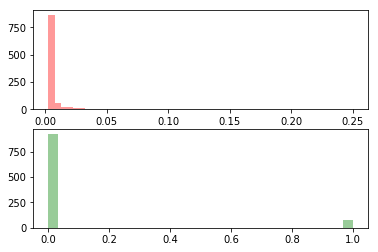

In [843]:
def evaluate(X, y):
    preds = model.predict(X)
    print('Predictions')
    print(pd.Series(preds.reshape(len(preds))).describe())
    print('y')
    print(pd.Series(y).describe())
    print('Predictions vs y')
    fig, (ax, ax2) = plt.subplots(nrows= 2)
    sea.distplot(preds, kde = False, ax = ax, color = 'red')

    sea.distplot(y, kde = False, ax = ax2, color = 'green')
    print('green = y | red = preds')
    plt.show()
    
    
evaluate(X[:1000], y[:1000])

In [832]:
data = pd.DataFrame()
data['preds'] = preds.reshape(len(preds))
data['y'] = y[:100]

data[data['preds'] > 0]['y'].value_counts()

0.0    100
Name: y, dtype: int64